In [92]:
!pip install fastdtw

In [93]:
from typing import Tuple, List

import numpy as np
import matplotlib.pyplot as plt
import fastdtw
%matplotlib inline

### Пример работы.

In [14]:
# сгенерируем два временных ряда, сдвинутых относительно друг друга

In [123]:
ts_1 = np.array([np.sin(x/4) for x in range(0, 30)])
ts_2 = np.array([np.sin(x/4) for x in range(5, 35)])

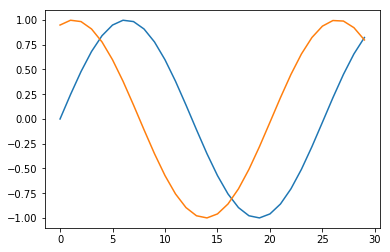

In [124]:
# видим, что обычная евклидова мера в данном случае сработает плохо 
plt.plot(ts_1)
plt.plot(ts_2)

In [125]:
dtw, path = fastdtw.dtw(ts_1, ts_2)

In [126]:
dtw

3.0718153171786056

In [127]:
path

[(0, 0),
 (1, 0),
 (2, 0),
 (3, 0),
 (4, 0),
 (5, 0),
 (6, 1),
 (7, 2),
 (8, 3),
 (9, 4),
 (10, 5),
 (11, 6),
 (12, 7),
 (13, 8),
 (14, 9),
 (15, 10),
 (16, 11),
 (17, 12),
 (18, 13),
 (19, 14),
 (20, 15),
 (21, 16),
 (22, 17),
 (23, 18),
 (24, 19),
 (25, 20),
 (26, 21),
 (27, 22),
 (28, 23),
 (29, 24),
 (29, 25),
 (29, 26),
 (29, 27),
 (29, 28),
 (29, 29)]

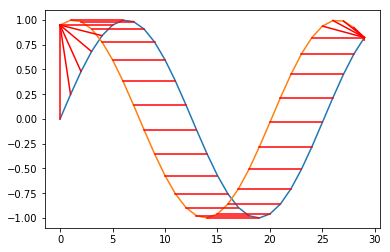

In [128]:
# в то время, как dynamic time warping ставит в соответствие именно те точки, которые нужны
plt.plot(ts_1)
plt.plot(ts_2)
for pair in path:
    plt.plot(pair, [ts_1[pair[0]], ts_2[pair[1]]], 'r-')

## Практика: наивная имплементация DTW.

### Задание 1. Реализуйте матрицу расстояний d_matrix

In [100]:
def make_distance_matrix(ts_1: np.array, ts_2: np.array) -> np.array:
    """
    Должна вернуть матрицу размерности (len(ts_1), len(ts_2)),
    в которой каждый элемент (i, j) равен евклидовому расстоянию от 
    точки ts_1[i] до точки ts_2[j]
    """
    # ваш код здесь
    d_matrix = ts_1.reshape(-1,1) - ts_2.reshape(1, -1)
    return np.abs(d_matrix)

### Задание 2. Реализуйте функцию поиска соседей get_ancestors. 

* принимает на входе произвольные координаты `i, j` и матрицу `matrix`
* для данных координат функция должна получить значения его соседей сверху `(i-1, j)`, слева `(i, j-1)` и по диагонали наверху `(i-1, j-1)`
* если соседа нет, вернуть бесконечность `np.inf`

In [101]:
def get_ancestors(i: int, j: int, matrix: np.array) -> Tuple[int]:
    left_ind, up_ind = j - 1, i - 1
    
    if left_ind >= 0 and up_ind >= 0:
        up, left, diag = matrix[up_ind, j], matrix[i, left_ind], matrix[up_ind, left_ind]
    
    elif left_ind >= 0 and up_ind < 0:
        up, left, diag = np.inf, matrix[i, left_ind], np.inf
    
    elif left_ind < 0 and up_ind >= 0:
        up, left, diag = matrix[up_ind, j], np.inf, np.inf
        
    elif left_ind < 0 and up_ind < 0:
        up, left, diag = np.inf, np.inf, np.inf
        
    return up, left, diag

### Задание 3. Реализуйте матрицу разностей D.

* принимает на вход матрицу расстояний `d_matrix`
* инициализирует матрицу D нулями (размерность матрицы равна размерности d_matrix)
* в двойном цикле проходится по всем элементам матрицы
* для каждого элемента i, j заполняет его значение по формуле `D(i, j) = d_{ij} + min(D_{i-1, j}, D_{i-1, j-1}, D_{i, j-1}`

In [112]:
def make_difference_matrix(d_matrix):
    """
    Должна возвращать матрицу D, в которой каждый элемент высчитывается как 
    D(i, j) = d_{ij} + min(D_{i-1, j}, D_{i-1, j-1}, D_{i, j-1})
    """
    # <ваш код здесь>
    D = np.zeros_like(d_matrix)
    x, y = d_matrix.shape
    for x_i in range(x):
        for y_i in range(y):
            if x_i == 0 and y_i == 0:
                D[x_i, y_i] = d_matrix[x_i, y_i]
                continue
            ancestors = get_ancestors(x_i, y_i, D)
            D[x_i, y_i] = d_matrix[x_i, y_i] + np.min(np.array(ancestors))
        
    return D

### Задание 4. Реализуйте функцяи поиска наименьшего пути и значения dtw. 

* принимает на входе два временных ряда, матрицу разностей D и матрицу расстояний d_matrix
* инициализирует путь пустым списком и добавляет туда первую коррдинату (len(ts_1)-1, len(ts_2)-1))
* проходит с нижнего правого до верхнего левого угла и добавляет координаты соседей с минимальным значением D
* переворачивает список пути
* расчитывает dtw по формуле `for i, j in path: dtw += d_matrix[i, j]`
* возвращает путь и значение dtw

In [118]:
def find_path_and_dtw(ts_1: np.array, ts_2: np.array, D: np.array, d_matrix: np.array) -> Tuple[List[Tuple], float]:
    """
    Функция должна возвращать путь от точки (len(ts_1), len(ts_2)) до точки (0, 0)
    в виде списка из координат (i, j), а также значение dtw. 
    """
    path = []
    dtw = 0
    i = len(ts_1)-1
    j = len(ts_2)-1

    path.append((i, j))
    
    while i+j > 0:
        if i-1 <0 and j-1 <0:
            min_ = (0, 0)
            break
        elif i-1 < 0:
            min_ = (i, j-1)
            j -= 1
        elif j-1 < 0:
            min_ = (i-1, j)
            i -= 1
        else:
            min_ = min(
                [
                    ((i-1, j), D[i-1, j]),
                    ((i, j-1), D[i, j-1]),
                    ((i-1, j-1), D[i-1, j-1])
                ],
                key=lambda x: x[1]
            )[0]
            
        i, j = min_
        path.append(min_)

    path = path[::-1]
    for i, j in path:
        dtw += d_matrix[i, j] 
    return path, dtw
#     return path

In [119]:
d_matrix = make_distance_matrix(ts_1, ts_2)

In [120]:
D = make_difference_matrix(d_matrix)

In [121]:
a = find_path_and_dtw(ts_1, ts_2, D, d_matrix)

In [122]:
a

([(0, 0),
  (0, 1),
  (1, 2),
  (2, 3),
  (3, 4),
  (4, 5),
  (5, 6),
  (6, 7),
  (7, 8),
  (8, 9),
  (9, 10),
  (10, 11),
  (11, 12),
  (12, 13),
  (13, 14),
  (14, 15),
  (15, 16),
  (16, 17),
  (17, 18),
  (18, 19),
  (19, 20),
  (20, 21),
  (21, 22),
  (22, 23),
  (23, 24),
  (24, 25),
  (25, 26),
  (26, 27),
  (27, 28),
  (28, 29),
  (29, 29)],
 7.4277709902429745)